# Work spatial patterns in Greater London

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import ipywidgets as widgets
from IPython.display import display
import warnings
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from esda.moran import Moran, Moran_Local
from libpysal.weights.contiguity import Queen
from splot.esda import moran_scatterplot, lisa_cluster
from gap_statistic import OptimalK


## Loading and pre-processing the data

Index(['ward code', 'ward name', 'local authority code',
       'local authority name', 'hours_worked - 15 hours or less',
       'hours_worked - 16 to 30 hours', 'hours_worked - 31 to 48 hours',
       'hours_worked - 49 or more hours', 'distance_traveled - Less than 2km',
       'distance_traveled - 2km to less than 5km',
       'distance_traveled - 5km to less than 10km',
       'distance_traveled - 10km to less than 20km',
       'distance_traveled - 20km to less than 30km',
       'distance_traveled - 30km to less than 40km',
       'distance_traveled - 40km to less than 60km',
       'distance_traveled - 60km and over',
       'distance_traveled - Works mainly from home',
       'distance_traveled - Other',
       'occupation - Managers, directors and senior officials',
       'occupation - Professional occupations',
       'occupation - Associate professional and technical occupations',
       'occupation - Adminis-trative and secretarial occupations',
       'occupation - Skill

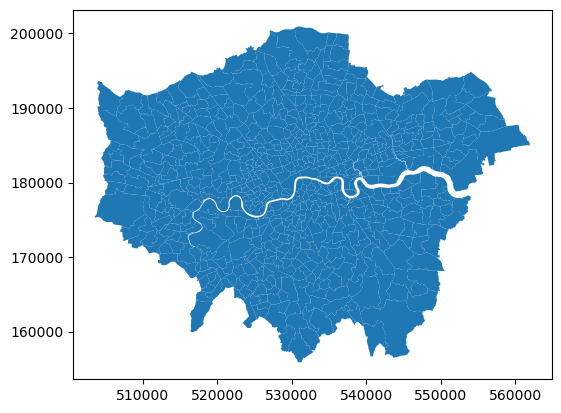

In [2]:
# Define file paths for all the datasets
dataset_file_paths = {
    'hours_worked': './data/hours worked.xlsx',
    'distance_traveled': './data/Distance traveled to work.xlsx',
    'occupation': './data/occupation.xlsx',
    'nssec': './data/NSSEC.xlsx',
    'method_travel': './data/Method of travel to work.xlsx',
    'economic_activity': './data/Economic Activity.xlsx'
}

# Initialize an empty DataFrame for merging
merged_df = pd.DataFrame()

# Define common columns that should not be repeated
common_columns = ['ward code', 'ward name', 'local authority code', 'local authority name']

# Function to normalise specified columns in a dataframe
def normalise_columns(dataframe, columns_to_normalise, total_column):
    for column in columns_to_normalise:
        dataframe[column] = dataframe[column] / dataframe[total_column]
    return dataframe

# Process and merge each dataset
for dataset, file_path in dataset_file_paths.items():
    data = pd.read_excel(file_path, sheet_name='2021')

    # Identify the total population column based on the dataset
    total_column = 'All usual residents aged 16+ in employment' if dataset in ['hours_worked', 'distance_traveled', 'occupation', 'method_travel'] else 'All usual residents aged 16+'

    # Normalise the dataframe
    columns_to_normalise = [column for column in data.columns if column not in common_columns + [total_column]]
    data = normalise_columns(data, columns_to_normalise, total_column)

    # Rename columns to include dataset key and remove leading numbers from 'occupation' columns
    data.rename(columns={column: f"{dataset} - {column.split('. ')[-1]}" if dataset == 'occupation' else f"{dataset} - {column}" for column in data.columns if column not in common_columns + [total_column, 'ward code']}, inplace=True)

    # Merge the dataframe
    if merged_df.empty:
        merged_df = data
    else:
        # Exclude 'total_column' from the merged dataframe
        columns_to_merge = [column for column in data.columns if column not in common_columns + [total_column] or column == 'ward code']
        merged_df = pd.merge(merged_df, data[columns_to_merge], on='ward code', how='outer')

# Remove the 'All usual residents aged 16+ in employment' column from the final dataframe
merged_df = merged_df.drop(columns=['All usual residents aged 16+ in employment'])

# Display the columns of the normalised dataframe
merged_df.columns

# Read the geopackage for UK wards
wards_greater_london = gpd.read_file('./data/wards_greater_london.gpkg')

# Modifying 'City of London' ward code before merging to have City of London as ward with code E09000001 not to miss data
wards_greater_london.loc[wards_greater_london['LAD23NM'] == 'City of London', 'WD23CD'] = 'E09000001'

# Merge the dataframes if 'ward code' is in merged_df.columns
if 'ward code' in merged_df.columns:
    merged_df = merged_df[merged_df['ward code'].isin(wards_greater_london['WD23CD'])]
gdf = gpd.GeoDataFrame(merged_df.merge(wards_greater_london, left_on='ward code', right_on='WD23CD', how='inner'))

# Combine all geometries with ward code 'E09000001' into one
gdf.loc[gdf['ward code'] == 'E09000001', 'geometry'] = gdf.loc[gdf['ward code'] == 'E09000001', 'geometry'].unary_union

# Remove unwanted columns
gdf = gdf.drop(columns=['WD23CD', 'WD23NM', 'WD23NMW', 'LAD23CD', 'LAD23NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT', 'GlobalID'])

# Remove duplicate rows with ward code 'E09000001'
gdf = gdf.drop_duplicates(subset=['ward code'], keep='first')

# Plot the GeoDataFrame and display its columns
gdf.plot()
gdf.columns

Original DataFrame shape: (680, 63)
Number of outliers detected: 152
Percentage of outliers: 22.35%
Note: We are not removing the outliers as we plan to perform clustering using mean linkage which is more robust to outliers.
This is to ensure we have representative data for every ward.


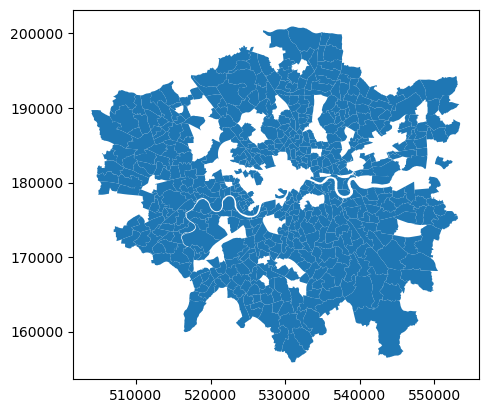

In [3]:
# Handling missing values and duplicates
numeric_cols = gdf.select_dtypes(include=[np.number]).columns.tolist()
print("Original DataFrame shape:", gdf.shape)
gdf[numeric_cols] = gdf[numeric_cols].fillna(gdf[numeric_cols].mean())
gdf = gdf.drop_duplicates()

# Detecting outliers using Z-score
z_scores = np.abs(stats.zscore(gdf[numeric_cols]))
outliers = (z_scores > 3).any(axis=1)

# Count the number of outliers
num_outliers = np.sum(outliers)
total_rows = gdf.shape[0]
percentage_outliers = (num_outliers / total_rows) * 100

# Print the number of outliers detected and their percentage
print("Number of outliers detected:", num_outliers)
print("Percentage of outliers:", str(round(percentage_outliers, 2)) + "%")

# Print the note about not removing outliers
print("Note: We are not removing the outliers as we plan to perform clustering using mean linkage which is more robust to outliers.")
print("This is to ensure we have representative data for every ward.")

# Create a new GeoDataFrame without outliers for plotting
gdf_without_outliers = gdf[~outliers]

# Plotting the processed GeoDataFrame without outliers
gdf_without_outliers.plot()
plt.show()

## Summary statistics

In [4]:
gdf.describe()

,hours_worked - 15 hours or less,hours_worked - 16 to 30 hours,hours_worked - 31 to 48 hours,hours_worked - 49 or more hours,distance_traveled - Less than 2km,distance_traveled - 2km to less than 5km,distance_traveled - 5km to less than 10km,distance_traveled - 10km to less than 20km,distance_traveled - 20km to less than 30km,distance_traveled - 30km to less than 40km,...,economic_activity - Self employed without employees Part time,economic_activity - Self employed without employees Full time,economic_activity - Unemployed,economic_activity - Economically active Full time student,economic_activity - Economically inactive Total,economic_activity - Economically inactive: retired,economic_activity - Economically inactive full time students,economic_activity - Looking after home or family,economic_activity - Long term sick or disabled,economic_activity - Economically inactive: other
count,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,...,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000
mean,0.107471,0.174770,0.583030,0.134730,0.077069,0.111831,0.120915,0.093864,0.018667,0.005365,...,0.046127,0.057046,0.040503,0.026634,0.338401,0.129940,0.072073,0.059549,0.035846,0.040994
std,0.016508,0.039600,0.042894,0.054326,0.030022,0.032982,0.033745,0.046840,0.017749,0.003233,...,0.010200,0.011176,0.009871,0.011271,0.051221,0.052255,0.029105,0.019274,0.013432,0.012243
min,0.053614,0.075105,0.389194,0.056428,0.022234,0.021707,0.042423,0.014452,0.001693,0.000000,...,0.022993,0.027328,0.018286,0.008997,0.156879,0.013102,0.031627,0.023775,0.008935,0.016595
25%,0.097691,0.149802,0.564068,0.096800,0.056836,0.087956,0.098346,0.044839,0.007009,0.002929,...,0.038615,0.050117,0.032766,0.018471,0.307307,0.091040,0.054417,0.045557,0.026047,0.031982
50%,0.107222,0.175954,0.589520,0.118635,0.071721,0.108247,0.119771,0.102204,0.012322,0.004647,...,0.044900,0.056874,0.040716,0.025033,0.342885,0.117391,0.065885,0.055101,0.034481,0.039977
75%,0.117863,0.196407,0.610243,0.153962,0.090026,0.133109,0.141003,0.130462,0.022527,0.007333,...,0.052606,0.063058,0.047790,0.031801,0.373093,0.162717,0.081994,0.068404,0.044224,0.048506
max,0.168033,0.391824,0.681316,0.362702,0.281727,0.224924,0.279177,0.221167,0.101073,0.021036,...,0.083927,0.113290,0.070303,0.124152,0.520064,0.299900,0.336059,0.139326,0.090946,0.131783


In [5]:
# Select numerical columns for correlation matrix and PCA
numerical_columns = gdf.select_dtypes(include=[np.number]).columns.tolist()

# Generate correlation matrix
corr_matrix = gdf[numerical_columns].corr()

# Create a heatmap of the correlation matrix using plotly
import plotly.graph_objects as go
heatmap = go.Figure(data=go.Heatmap(z=corr_matrix.values, x=list(corr_matrix.columns), y=list(corr_matrix.index), colorscale='RdBu'))
heatmap.update_layout(autosize=True, height=1400)
print("We have " + str(len(gdf.columns)) + " variables for our analysis.")
heatmap.show()


We have 63 variables for our analysis.


In [6]:
 # Initialize an empty set to store the names of highly correlated variables
 correlated = set()

 # Define a threshold for correlation
 threshold = 0.8

 # Loop through the correlation matrix. The 'abs' function ensures that both highly positively and negatively correlated variables are considered.
 # If the absolute correlation between two variables is greater than the threshold, add the variable name to the 'correlated' set.
 for i in range(len(corr_matrix.columns)):
     for j in range(i):
         if abs(corr_matrix.iloc[i, j]) > threshold:
             colname = corr_matrix.columns[i]
             correlated.add(colname)

 # Drop the highly correlated variables from the dataframe. The 'errors' parameter is set to 'ignore' to avoid errors if a column is not present in the dataframe.
 gdf_non_correlated = gdf.drop(columns=correlated, errors='ignore')

 # Select numerical columns for the new correlation matrix
 numerical_columns = gdf_non_correlated.select_dtypes(include=[np.number]).columns.tolist()

 # Generate a new correlation matrix after dropping the highly correlated variables
 corr_matrix = gdf_non_correlated[numerical_columns].corr()

 # Create a heatmap of the new correlation matrix using plotly
 heatmap = go.Figure(data=go.Heatmap(z=corr_matrix.values, x=list(corr_matrix.columns), y=list(corr_matrix.index), colorscale='RdBu'))
 heatmap.update_layout(autosize=True, height=1400)

print("Now we have " + str(len(gdf_non_correlated.columns)) + " variables after removing highly correlated variables.")
heatmap.show()



Now we have 34 variables after removing highly correlated variables.


In [7]:
# Create a spatial weights matrix
w = Queen.from_dataframe(gdf_non_correlated)
w.transform = 'r'

# Identify numeric columns
numeric_cols = gdf_non_correlated.select_dtypes(include=['number']).columns

# Standardize the data
scaler = StandardScaler()
gdf_non_correlated[numeric_cols] = scaler.fit_transform(gdf_non_correlated[numeric_cols])

# Define a colormap for consistency
cmap = 'coolwarm'

# Function to plot the selected variables
def plot_selected_variables(cols):
    for col in cols:
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 5))

        with warnings.catch_warnings():
            # Ignore warnings in this block
            warnings.simplefilter("ignore")

            # Compute Global Moran's I
            moran = Moran(gdf_non_correlated[col], w)

            # Compute Local Moran's I
            moran_local = Moran_Local(gdf_non_correlated[col], w)

            # Choropleth Map
            gdf_non_correlated.plot(column=col, ax=axes[0], legend=True, cmap=cmap, vmin=-2, vmax=2)
            axes[0].set_title(f"Choropleth Map of {col}")
            axes[0].axis('off')

            # LISA Cluster Map
            lisa_cluster(moran_local, gdf_non_correlated, ax=axes[1])
            axes[1].set_title(f"LISA Cluster Map of {col}")
            axes[1].axis('off')

            # Moran Scatterplot
            moran_scatterplot(moran, ax=axes[2])
            axes[2].set_title(f"Moran Scatterplot of {col}")

            # Histogram
            sns.histplot(gdf_non_correlated[col], bins=30, ax=axes[3], kde=True)

        plt.tight_layout()
        plt.show()

# SelectMultiple widget for variable selection
select = widgets.SelectMultiple(
    options=numeric_cols,
    value=[numeric_cols[0]],
    description='Variables',
    disabled=False
)

# Display the SelectMultiple widget and plot the selected variables
widgets.interact(plot_selected_variables, cols=select)

/var/folders/ws/t5rn8lfd1m71dktv64gnqgjc0000gn/T/ipykernel_54652/3060592.py:2: FutureWarning:

`use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning



interactive(children=(SelectMultiple(description='Variables', index=(0,), options=('hours_worked - 15 hours or…

<function __main__.plot_selected_variables(cols)>

## PCA (feature extraction and dimension reducciton)

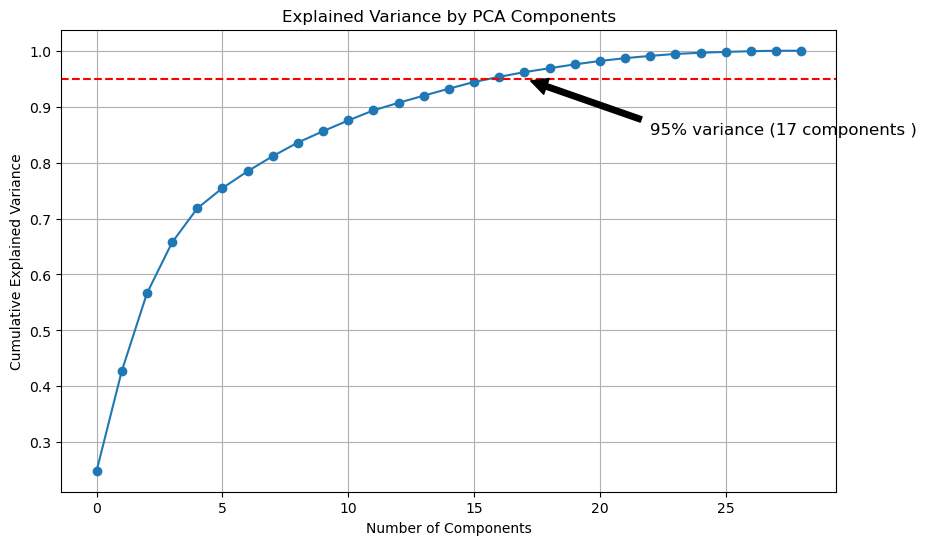

 Now we have 17 components after applying PCA.


In [8]:
# --- Standardizing the data ---
scaler = StandardScaler()
gdf_scaled = scaler.fit_transform(gdf_non_correlated[numeric_cols])

# --- Applying PCA ---
pca = PCA()
gdf_pca = pca.fit_transform(gdf_scaled)

# --- Explained Variance to decide the number of components ---
explained_variance = pca.explained_variance_ratio_.cumsum()

# Determine the number of components for 95% variance
num_components = np.where(explained_variance > 0.95)[0][0] + 1

# Plotting the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)

# Add a horizontal line at the 95% variance
plt.axhline(y=0.95, color='r', linestyle='--')

# Add an annotation for the number of components
plt.annotate(f'95% variance ({num_components} components )', xy=(num_components, 0.95), xytext=(num_components+5, 0.85),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)

plt.show()
pca = PCA(n_components=17)
gdf_pca = pca.fit_transform(gdf_scaled)

# Convert the numpy array to a DataFrame
gdf_pca_df = pd.DataFrame(gdf_pca, columns=[f'PC{i+1}' for i in range(gdf_pca.shape[1])])


print(" Now we have " + str(len(gdf_pca_df.columns)) + " components after applying PCA.")


## Clustering

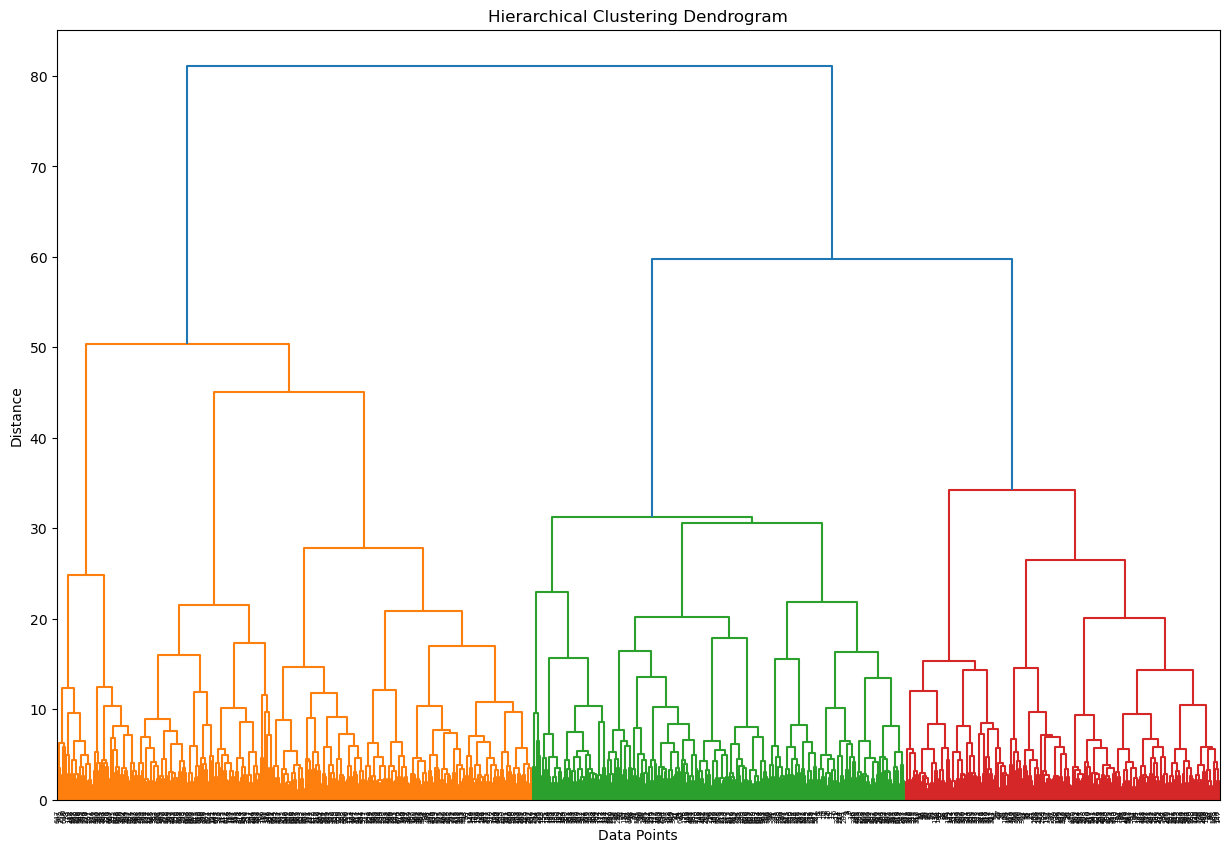

In [9]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Assuming gdf_pca_df is the DataFrame containing the PCA-transformed data

# Hierarchical Clustering with Ward's method
Z = linkage(gdf_pca_df, method='ward')

# Plotting the Dendrogram for Hierarchical Clustering
plt.figure(figsize=(15, 10))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

# Explanation:
# This plot (dendrogram) visualizes the hierarchical clustering process, 
# showing how data points are grouped together at different levels of similarity.
# It illustrates the arrangement of the clusters produced by the hierarchical clustering 
# and how each cluster is combined. The dendrogram is essential for understanding the 
# hierarchical structure of the data and can guide the decision on the number of clusters to use.



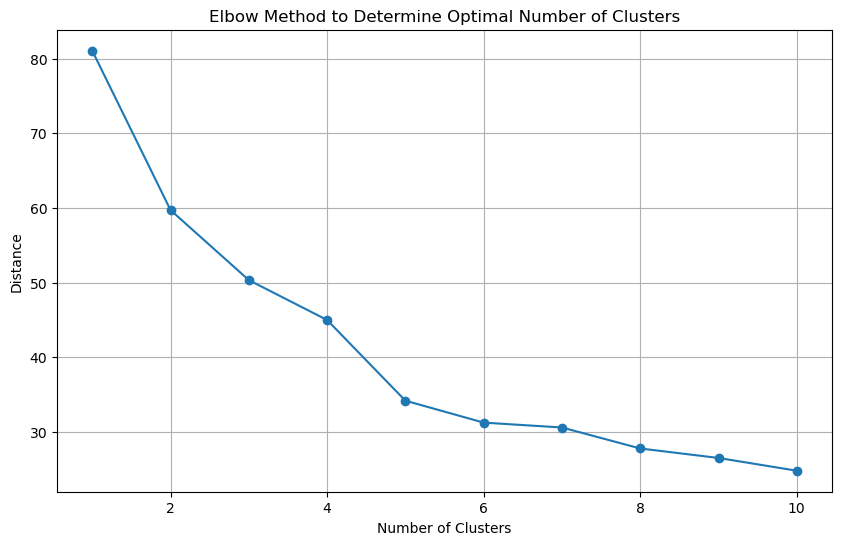

Optimal number of clusters according to elbow method: 4


In [10]:
# Second Chunk of Code: Elbow Method for Optimal Number of Clusters

# Extracting the last 10 merged clusters
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(idxs, last_rev, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distance')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.grid(True)
plt.show()

# Using the second derivative of the distances to find the elbow point
num_clusters = idxs[np.argmin(np.diff(last_rev, 2)) + 1]
print(f'Optimal number of clusters according to elbow method: {num_clusters}')

# Explanation:
# This plot shows the distances at which the last 10 merges in the hierarchical clustering occurred.
# The 'elbow' in this plot helps in identifying a good balance point for the number of clusters:
# It's where the rate of decrease sharply changes, suggesting that adding more clusters beyond this point 
# doesn't provide much better modeling of the data.
# The number of clusters at this 'elbow' point is considered optimal for clustering.


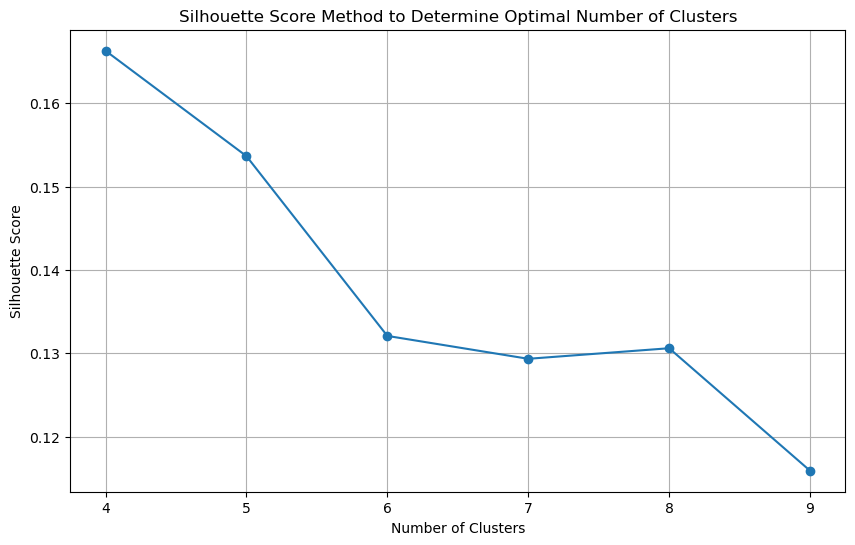

Optimal number of clusters according to silhouette score: 4


In [11]:
# Silhouette Score for Optimal Cluster Number

# Silhouette Score Calculation for different numbers of clusters
silhouette_scores = []
for i in range(4, 10):
    clusterer = AgglomerativeClustering(n_clusters=i, linkage='ward')
    preds = clusterer.fit_predict(gdf_pca_df)
    score = silhouette_score(gdf_pca_df, preds)
    silhouette_scores.append(score)

# Plotting the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(4, 10), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method to Determine Optimal Number of Clusters')
plt.grid(True)
plt.show()

# Finding the optimal number of clusters based on silhouette score
optimal_clusters_silhouette = silhouette_scores.index(max(silhouette_scores)) + 4
print(f'Optimal number of clusters according to silhouette score: {optimal_clusters_silhouette}')

# Explanation:
# The silhouette score plot helps in determining the quality of clusters formed.
# A higher silhouette score indicates better defined and separated clusters.
# The optimal number of clusters is where the silhouette score is maximized.


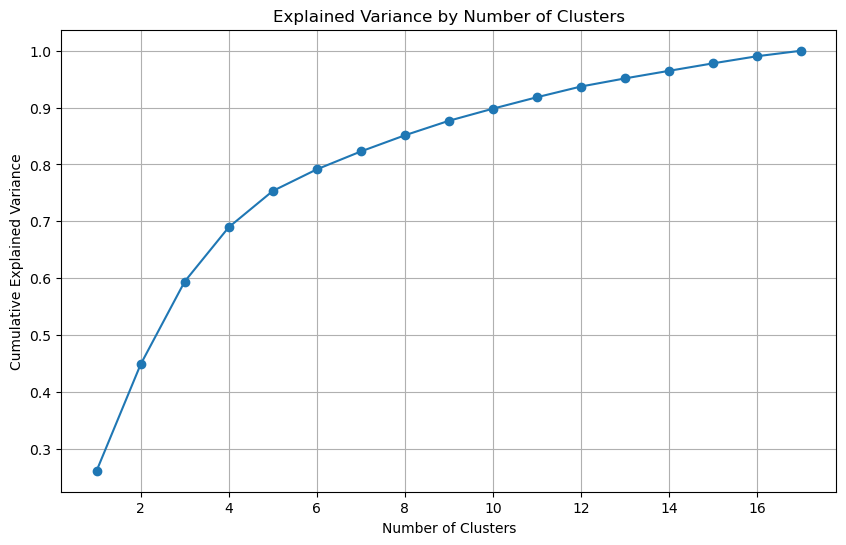

Total variance explained by 4 clusters: 68.96%


/var/folders/ws/t5rn8lfd1m71dktv64gnqgjc0000gn/T/ipykernel_54652/542489586.py:20: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [12]:
# Explained Variance Analysis

# Calculate the percentage of variance explained by each of the selected clusters
explained_variance = np.var(gdf_pca_df, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

# Compute the cumulative explained variance
cum_explained_variance = np.cumsum(explained_variance_ratio)

# Plotting the Cumulative Explained Variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cum_explained_variance) + 1), cum_explained_variance, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Clusters')
plt.grid(True)
plt.show()

# Total variance explained by the optimal number of clusters
total_variance_explained = cum_explained_variance[optimal_clusters_silhouette - 1]
print(f'Total variance explained by {optimal_clusters_silhouette} clusters: {total_variance_explained * 100:.2f}%')

# Explanation:
# This plot shows the cumulative explained variance by the PCA components.
# The x-axis represents the number of PCA components, and the y-axis shows the cumulative variance explained by these components.
# This analysis helps in understanding how many components are needed to capture a significant portion of the data's variance.
# The printed output shows the total variance explained by the number of clusters identified as optimal by the silhouette score.


Optimal number of clusters based on gap statistic: 14


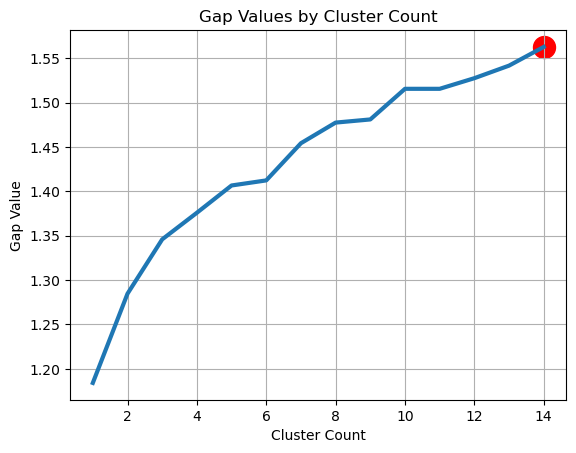

In [13]:
# Gap Statistic Analysis

# Create an instance of OptimalK
optimalK = OptimalK()

# Fit the data to the OptimalK model
n_clusters = optimalK(gdf_pca_df.values, n_refs=500, cluster_array=np.arange(1, 15))

# Print the optimal number of clusters
print('Optimal number of clusters based on gap statistic:', n_clusters)

# Plot the gap values
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

# Explanation:
# The gap statistic compares the total intra-cluster variation for different values of k with their expected values under null reference distribution of the data.
# The optimal number of clusters is the value that maximizes the Gap statistic.
# The plot shows the gap values for different numbers of clusters. The optimal number of clusters is where the gap value reaches its maximum.

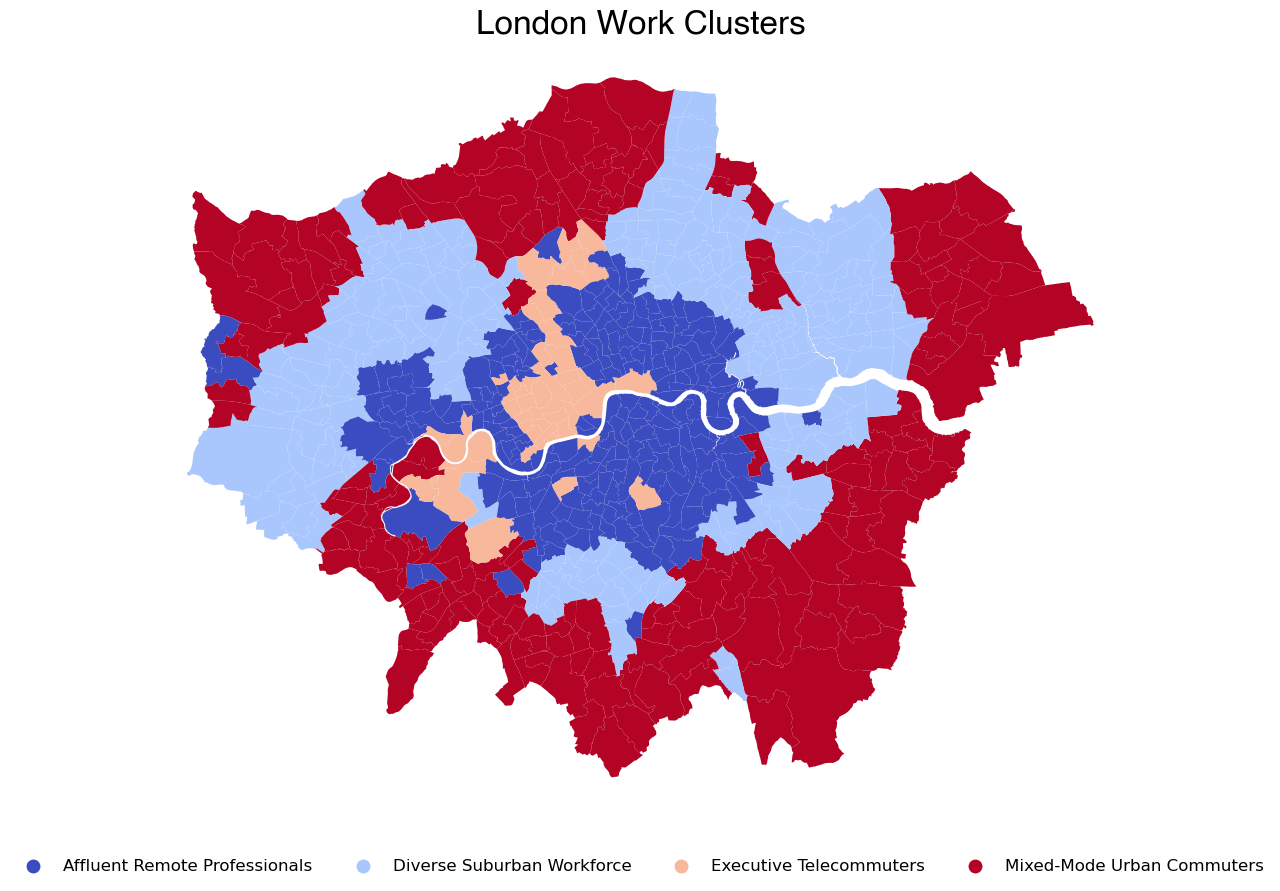

In [14]:
# Initialize the AgglomerativeClustering model with 4 clusters
# 'euclidean' metric is used to compute the distance between instances 
# 'ward' linkage minimizes the variance of the clusters being merged
clusterer = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
preds = clusterer.fit_predict(gdf_pca_df)

cluster_names = {
    0: "Affluent Remote Professionals",
    1: "Mixed-Mode Urban Commuters",
    2: "Diverse Suburban Workforce",
    3: "Executive Telecommuters"
}
gdf['cluster'] = preds
gdf['cluster'] = gdf['cluster'].replace(cluster_names)

# Create a map with improved legend and colorwarm colormap
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='cluster', cmap='coolwarm', legend=True, ax=ax, legend_kwds={'loc': 'lower center', 'bbox_to_anchor': (0.5,-0.1), 'ncol': 4, 'fontsize': 12})
legend = ax.get_legend()

ax.axis('off')
# Remove the legend frame and set a large, bold, Helvetica title at the top
legend.get_frame().set_linewidth(0.0)
plt.title('London Work Clusters', fontsize=24, fontweight='bold', fontname='Helvetica', loc='center')
plt.show()
